In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_num_correct(preds,labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [3]:
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6,out_channels=12,kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=12*4*4,out_features=120)
        self.fc2 = nn.Linear(in_features=120,out_features=60)
        self.out = nn.Linear(in_features=60,out_features=10)
        
    def forward(self,t):
        #the forward pass
        #pass through first conv layer
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2,stride = 2)
        #pass through 2nd conv layer
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2,stride = 2)
        #reshape for linear layer
        t = t.reshape(-1,12*4*4)
        #pass through first hidden linear/FC layer
        t = self.fc1(t)
        t = F.relu(t)
        #pass through 2nd FC layer
        t = self.fc2(t)
        t = F.relu(t)
        #finally pass it through output layer
        t = self.out(t)
        #t = F.softmax(t,dim=1)     -- Not using here since in loss function it is implemented
        return t

In [4]:
train_set = torchvision.datasets.FashionMNIST(
root = './data/FashionMNIST',
train = True,
download = True,
transform = transforms.Compose([transforms.ToTensor()]))

In [5]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 100)

## For all batches let's create a training loop that goes over all the data once (1 epoch)

In [9]:
network = Network()
optimizer = optim.Adam(network.parameters(),lr=0.01)

total_loss = 0
total_correct = 0

for batch in train_loader:
    images,labels = batch
    
    preds = network(images)
    loss = F.cross_entropy(preds,labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    total_loss = total_loss + loss.item()
    total_correct = total_correct + get_num_correct(preds,labels)
    
print("epoch:", 0, "total_loss:", total_loss, "total_correct:", total_correct, "accuracy:", total_correct/len(train_set))

epoch: 0 total_loss: 326.2736076414585 total_correct: 47778 accuracy: 0.7963


## For all batches let's create a training loop that goes over all the data multiple times
### (Multiple epochs)

In [10]:
network = Network()
optimizer = optim.Adam(network.parameters(),lr=0.01)

for epoch in range(5):
    
    total_loss = 0
    total_correct = 0

    for batch in train_loader:
        images,labels = batch
    
        preds = network(images)
        loss = F.cross_entropy(preds,labels)
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        total_loss = total_loss + loss.item()
        total_correct = total_correct + get_num_correct(preds,labels)
    
    print("epoch:", 0, "total_loss:", total_loss, "total_correct:", total_correct, "accuracy:", total_correct/len(train_set))

epoch: 0 total_loss: 346.5074330419302 total_correct: 46997 accuracy: 0.7832833333333333
epoch: 0 total_loss: 231.4143564850092 total_correct: 51448 accuracy: 0.8574666666666667
epoch: 0 total_loss: 213.5105157494545 total_correct: 52108 accuracy: 0.8684666666666667
epoch: 0 total_loss: 201.84973481297493 total_correct: 52589 accuracy: 0.8764833333333333
epoch: 0 total_loss: 196.3770968914032 total_correct: 52759 accuracy: 0.8793166666666666


In [12]:
torch.save(network,'fashionMnist-first.pt')

In [6]:
model = torch.load('fashionMnist-first.pt')
model.eval()

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)

### Getting predictions for entire dataset and creating a confusion matrix

In [7]:
def get_preds(model,loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images,labels = batch
        preds = model(images)
        all_preds = torch.cat((all_preds,preds),dim=0)
    return all_preds

#### Set the grad to no grad since we don't need an overhead computation while just predicting

In [8]:
#Also create a new data-loader with more batch size so as to run the predictions faster
with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(train_set,batch_size = 10000)
    train_preds = get_preds(model,prediction_loader)

In [9]:
preds_correct = get_num_correct(train_preds,train_set.targets)

print("Total correct:", preds_correct)
print("Accuracy:", preds_correct/len(train_set))

Total correct: 52867
Accuracy: 0.8811166666666667


### Building a confusion matrix

In [10]:
#we need all targets and all predicted classes for confusion matric creation
#we can get the predicted classes by looking at the argmax value of the output prediction tensors.
# Also lets stack all these

In [11]:
stacked = torch.stack((train_set.targets,train_preds.argmax(dim=1)),dim=1)

In [12]:
stacked.shape

torch.Size([60000, 2])

In [20]:
#!pip install resources.plotcm
from sklearn.metrics import confusion_matrix
from resources import *

In [21]:
cm = confusion_matrix(train_set.targets,train_preds.argmax(dim=1))

In [31]:
names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
import seaborn as sns

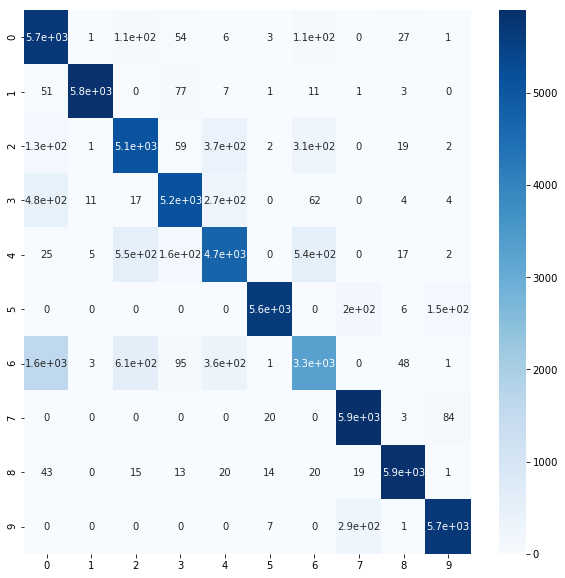

In [35]:
plt.figure(figsize=(10,10))
sns.heatmap(cm,annot=True,cmap='Blues')

## Let's build a better confusion matrix

In [39]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

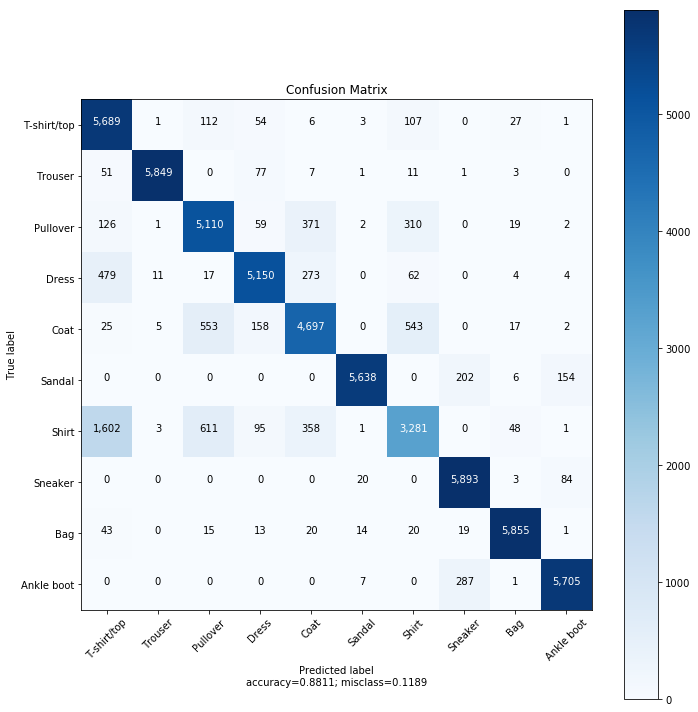

In [41]:
plot_confusion_matrix(cm, normalize    = False,
                      target_names = names,
                      title        = "Confusion Matrix",cmap=None)